In [1]:
import numpy as np 
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor
import time 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm

In [ ]:
"""
bu saatten sonra sadece data cleaning ve feature engineering le uğraş.
"""


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

In [3]:
trainData = pd.read_csv("train.csv")
testData = pd.read_csv("test.csv")

In [4]:
dataset =pd.concat([trainData,testData],axis=0)
dataset.reset_index(inplace=True)
del dataset["index"],dataset["Id"]

In [5]:
#dataset.drop(["Alley","FireplaceQu","PoolQC","Fence","MiscFeature"],axis=1,inplace=True)
dataset.drop(["Alley","PoolQC","Fence","MiscFeature"],axis=1,inplace=True)

In [6]:
print("Dataset unique data types",np.unique(dataset[dataset.columns].dtypes))
floatCols=np.where(dataset[dataset.columns].dtypes==np.float64)
objectCols=np.where(dataset[dataset.columns].dtypes==object)
intCols=np.where(dataset[dataset.columns].dtypes==np.int64)

Dataset unique data types [dtype('int64') dtype('float64') dtype('O')]


In [7]:
dataset.replace(to_replace = np.nan,value = dataset[dataset.columns[floatCols]].mean(),inplace=True)
dataset.replace(to_replace = np.nan,value = dataset[dataset.columns[intCols]].mean(),inplace=True)
#dataset.replace(to_replace = np.nan,value = dataset[dataset.columns[objectCols]].median(),inplace=True)

In [8]:
cols = dataset.columns
for col in cols:
    if dataset[col].dtype == object:
        dummies = pd.get_dummies(dataset[col],drop_first = False)
        dataset=pd.concat([dataset,dummies],axis=1)
        dataset.drop([col],axis=1,inplace=True)

In [9]:
logCols = ["LotFrontage","MasVnrArea","LotArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch","MiscVal"]

In [10]:
dataset.loc[:,logCols]=np.log(dataset.loc[:,logCols]+1)

In [53]:
trainArr = dataset.iloc[:1460-1,np.where(dataset.columns!="SalePrice")[0]].to_numpy()
targetArr = dataset.iloc[:1460-1,np.where(dataset.columns=="SalePrice")[0][0]].to_numpy()

In [54]:
xTrain = np.array(trainArr[:int(trainArr.shape[0])])
yTrain = np.array(targetArr[:int(trainArr.shape[0])])

In [55]:
xTrain.shape,yTrain.shape

((1459, 275), (1459,))

In [56]:
mins=np.min(dataset.iloc[:,np.where(dataset.columns!="SalePrice")[0]].to_numpy(),axis=0)
maxs=np.max(dataset.iloc[:,np.where(dataset.columns!="SalePrice")[0]].to_numpy(),axis=0)

In [57]:
#maxs = np.max(trainArr,axis=0)
#mins = np.min(trainArr,axis=0)

xTrain = (xTrain-mins)/(maxs-mins)
yTrain = np.log10(yTrain)

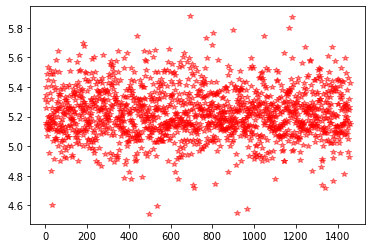

In [58]:
plt.plot(yTrain,"r*",alpha=0.5)
plt.show()

In [59]:
ridgeRegressor = Ridge(alpha=1.5)
ridgeRegressor.fit(xTrain,yTrain)

Ridge(alpha=1.5)

In [60]:
xTrain = np.delete(xTrain,np.where((ridgeRegressor.coef_<0.01)&((ridgeRegressor.coef_>-0.01)))[0],axis=1)

In [61]:
xTrain.shape

(1459, 145)

In [62]:
gbRegressor = GradientBoostingRegressor(n_estimators=1000,max_depth=3,random_state=0)

In [63]:
gbRegressor.fit(xTrain,yTrain)

GradientBoostingRegressor(n_estimators=1000, random_state=0)

In [64]:
gbRegressor.score(xTrain,yTrain)

0.9959422516439044

In [65]:
predArr = dataset.iloc[1460:,np.where(dataset.columns!="SalePrice")[0]].to_numpy()

In [66]:
predArr = (predArr-mins)/(maxs-mins)

In [67]:
predArr = np.delete(predArr,np.where((ridgeRegressor.coef_<0.01)&((ridgeRegressor.coef_>-0.01)))[0],axis=1)

In [68]:
predictions=gbRegressor.predict(predArr)

In [69]:
predictions=np.power(10,predictions)

In [70]:
submission = pd.read_csv("sample_submission.csv")

In [71]:
submission["SalePrice"]=predictions

In [46]:
submission

,Id,SalePrice
0,1461,123324.789888
1,1462,152846.557359
2,1463,193124.029151
3,1464,190403.751950
4,1465,178640.010411
...,...,...
1454,2915,73602.653214
1455,2916,87738.189142
1456,2917,154687.393687
1457,2918,111891.803348


In [72]:
submission

,Id,SalePrice
0,1461,122907.623903
1,1462,162051.144766
2,1463,190622.712312
3,1464,191927.696244
4,1465,181660.633161
...,...,...
1454,2915,76631.189306
1455,2916,85389.748969
1456,2917,149062.683977
1457,2918,114201.360997


In [993]:
submission

,Id,SalePrice
0,1461,115555.816981
1,1462,155514.427025
2,1463,193955.827887
3,1464,193572.268236
4,1465,183933.654192
...,...,...
1454,2915,77581.787599
1455,2916,77537.013681
1456,2917,159804.513998
1457,2918,115673.141794


In [73]:
submission.to_csv('submission5.csv', index=False)

In [74]:
np.max(submission)

Id             2919.000000
SalePrice    567049.533298
dtype: float64